Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [78]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from numpy.typing import NDArray
import geopy.distance

from tqdm.auto import tqdm
from icecream import ic

import os
import matplotlib.pyplot as plt
import cv2
import re

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

https://en.wikipedia.org/wiki/Travelling_salesman_problem

# Setup

## Environment

In [79]:
IMG_FOLDER = 'imgs'
OUTPUT_PATH = 'out'
VIDEO_NAME = 'video.avi'

if not os.path.exists(IMG_FOLDER):
    os.makedirs(IMG_FOLDER)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## Universe

In [80]:
CITIES: pd.DataFrame = (
    pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
    # sorting by lat and lon
    # TODO: consider sorting by relative distance, but this would immediately solve the TSP
    # so i guess I'm finding this with the algorithm below
    .sort_values(by=['lat', 'lon']).reset_index(drop=True)
)

NUM_CITIES: int = len(CITIES)

DIST_MATRIX: np.ndarray = np.zeros((len(CITIES), len(CITIES)), dtype=np.float64)
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

# Plotting Cities Position

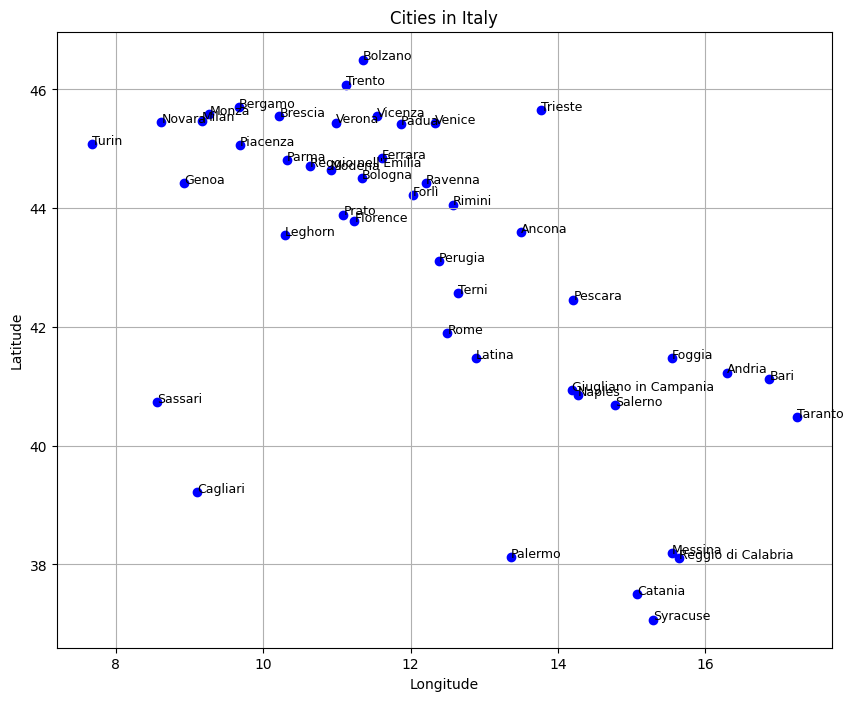

In [81]:
plt.figure(figsize=(10, 8))
plt.scatter(CITIES['lon'], CITIES['lat'], c='blue', marker='o')
for i, city in CITIES.iterrows():
    plt.text(city['lon'], city['lat'], city['name'], fontsize=9)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities in Italy')
plt.grid(True)
plt.show()

# Utility

In [82]:
def cooldown(T: float, alpha: float = 90) -> float:
    return T * alpha / 100  # (1 + alpha * T)


# def valid(solution: NDArray[np.int64] | list[int]) -> bool:
#     return len(set(solution)) == len(CITIES)


def cost(individual: NDArray[np.int64] | list[int] ) -> np.float64:
    cumulative_dist: np.float64 = np.float64(0)
    for c1, c2 in zip(individual, individual[1:]):
        cumulative_dist += np.float64(DIST_MATRIX[c1, c2])
    return cumulative_dist


def mutation(individual: NDArray[np.int64], p: float = 0.1) -> NDArray[np.int64]:
    a = individual.copy()
    i, j = np.random.choice(range(1, len(a) - 1), 2, replace=False)
    a[i], a[j] = a[j], a[i]
    return a


def xover(individual_a: NDArray[np.int64], individual_b: NDArray[np.int64], mutation_rate: float) -> NDArray[np.int64]:
    a, b = individual_a.copy(), individual_b.copy()
    mask = np.random.rand(len(a)) < 0.5
    # Avoid selecting index 0 and last
    mask[0] = mask[-1] = False
    child = np.full_like(a, -1)
    child[mask] = a[mask]
    b_idx = 0
    for i in range(len(child)):
        if child[i] == -1:
            while b[b_idx] in child:
                b_idx += 1
            child[i] = b[b_idx]
    # Avoid selecting index 0 and last
    mask[0] = mask[-1] = False
    child = np.where(mask, a, b)
    if mutation_rate and np.random.rand() < mutation_rate:
        return mutation(child, mutation_rate)
    return child

## Recreational Utility

### Saving PNGs

In [83]:
def save_best_iteration(solution: list[int] | NDArray[np.int64], gen: int, display: bool = False) -> None:
    best_solution, path_lons, path_lats = None, None, None
    if isinstance(solution, list):
        path_lons = [CITIES.iloc[city]['lon'] for city in solution]
        path_lats = [CITIES.iloc[city]['lat'] for city in solution]
    else:  # numpy array
        path_lons = [CITIES.iloc[city]['lon'] for city in solution]
        path_lats = [CITIES.iloc[city]['lat'] for city in solution]
    plt.figure(figsize=(10, 8))
    plt.scatter(CITIES['lon'], CITIES['lat'], c='blue', marker='o')
    for _, city in CITIES.iterrows():
        plt.text(city['lon'], city['lat'], city['name'], fontsize=9)
    plt.plot(path_lons, path_lats, c='blue', linestyle='-', linewidth=1, marker='o', markerfacecolor='red')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Best Travel Path - Generation {gen}')
    plt.grid(True)
    plt.savefig(f'{IMG_FOLDER}/gen_{gen}.png')
    if display:
        plt.show()
    plt.close()

### Making a video out of the PNGs

In [87]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)


def make_video(img_folder: str = IMG_FOLDER, out_path: str = OUTPUT_PATH, video_name: str = VIDEO_NAME) -> None:
    images = [img for img in sorted_alphanumeric(os.listdir(img_folder)) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(img_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(f"{OUTPUT_PATH}/{video_name}", 0, 30, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(img_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Solution

In [85]:
POPULATION_SIZE = 100
MUTATION_RATE = 0.2
NUM_ELITES = 10

NUM_GENERATIONS = 1_000


class Individual:
    def __init__(self, genome: None | NDArray[np.int64] = None) -> None:
        # dictionary indexing as a ternary operator
        self.genome: NDArray[np.int64] = {True: genome, False: np.random.permutation(NUM_CITIES)}[genome is not None]

    # Define comparison operators
    def __le__(self, other: 'Individual') -> np.bool:
        return self.fitness() <= other.fitness()

    def __lt__(self, other: 'Individual') -> np.bool:
        return self.fitness() < other.fitness()

    def __ge__(self, other: 'Individual') -> np.bool:
        return self.fitness() >= other.fitness()

    def __gt__(self, other: 'Individual') -> np.bool:
        return self.fitness() > other.fitness()

    def __cmp__(self, other: 'Individual') -> np.int64:
        return np.sign(self.fitness() - other.fitness())

    def __len__(self) -> int:
        return len(self.genome)

    # Define item access operators
    def __getitem__(self, key: int | NDArray[np.bool]) -> np.int64 | NDArray[np.int64]:
        return self.genome[key]

    def __setitem__(self, key: int | NDArray[np.bool], value: np.int64 | NDArray[np.int64]) -> None:
        self.genome[key] = value

    # Define EA operators
    def mutate(self) -> None:
        g1, g2 = np.random.choice(NUM_CITIES, 2)
        self.genome[g1], self.genome[g2] = self.genome[g2], self.genome[g1]

    def cost(self) -> np.float64:
        cumulative_dist: np.float64 = np.float64(0)
        # if self.genome[0] != self.genome[-1]:
        #     self.genome = np.hstack((self.genome, self.genome[0]))

        for c1, c2 in zip(self.genome, self.genome[1:]):
            cumulative_dist += np.float64(DIST_MATRIX[c1, c2])
        return cumulative_dist

    def fitness(self) -> np.float64:
        return -self.cost()

    def is_valid(self) -> bool:
        return len(set(self.genome)) == NUM_CITIES

    def validate(self) -> None:
        if not self.is_valid():
            raise ValueError(f"Invalid individual: {self.genome}")

    # Finalize the genome by making the path circular
    # TODO: consider making the path circular from the beginning
    def finalize(self) -> NDArray[np.int64]:
        self.genome = np.hstack((self.genome, self.genome[0]))
        return self.genome


class Population:
    def __init__(self, size: int, mutation_rate: float, elite_size: int) -> None:
        self.size: int = size
        self.mutation_rate: float = mutation_rate
        self.individuals: list[Individual] = [Individual() for _ in range(size)]
        self.elite_size: int = elite_size
        self.generation: int = 0
        self.new_population: list[Individual] = [] * size

    def __getitem__(self, key: np.int64) -> Individual:
        return self.individuals[key]

    def get_top_parents(self, k: int) -> list[Individual]:
        return sorted(self.individuals, key=lambda e: float(e.fitness()), reverse=True)[:k]

    def xover(self, num_parents: int = 2) -> Individual:
        if num_parents != 2:
            raise ValueError("Only 2 parents are supported")
        p1, p2 = self.get_top_parents(num_parents)

        mask: NDArray[np.bool] = np.random.rand(len(p1)) < 0.5
        # Avoid selecting index 0 and last
        mask[0] = mask[-1] = False
        child = Individual(np.full(len(p1), -1, dtype=np.int64))
        child[mask] = p1[mask]
        p2_idx = 0
        for i in range(len(child.genome)):
            if child[i] == -1:
                while p2[p2_idx] in child:
                    p2_idx += 1
                child[i] = p2[p2_idx]
        # Avoid selecting index 0 and last
        mask[0] = mask[-1] = False
        # child = Individual(np.where(mask, p1.genome, p2.genome))
        if self.mutation_rate and np.random.rand() < self.mutation_rate:
            child.mutate()
        if not child.is_valid():
            raise ValueError(f"Invalid child: {child.genome}")
        return child

    def get_elites(self) -> list[Individual]:
        return sorted(self.individuals, key=lambda i: float(i.fitness()), reverse=True)[: self.elite_size]

    def evolve(self, save_iteration: bool = False, display: bool = False) -> None:
        elites: list[Individual] = self.get_elites()
        self.new_population = elites.copy()
        if save_iteration:
            save_best_iteration(elites[0].genome, gen, display)

        while len(self.new_population) < self.size:
            self.new_population.append(self.xover())

        self.individuals = self.new_population
        self.generation += 1

    def validate(self) -> None:
        for individual in self.individuals:
            individual.validate()

    def finalize(self) -> None:
        for individual in self.individuals:
            individual.finalize()


logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.DEBUG)


population: Population = Population(POPULATION_SIZE, MUTATION_RATE, NUM_ELITES)
population.validate()

for gen in tqdm(range(NUM_GENERATIONS)):
    population.evolve(save_iteration=True, display=False)
    population.validate()
    # Plot the best solution travel path at every iteration
population.finalize()
make_video()
best_traveler = population[np.argmin([individual.cost() for individual in population.individuals])]
logging.info(f"result: Found a path of {len(best_traveler.genome)-1} steps, total length {best_traveler.cost():.2f}km")

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO: result: Found a path of 46 steps, total length 5788.21km


In [88]:
make_video()

# Professor method

In [86]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp: list[int] = list()
tsp.append(int(city))
gen = 0
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    visited[closest] = True
    city = closest
    tsp.append(int(city))
    save_best_iteration(tsp, gen)
    gen += 1

logging.debug(f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)")
tsp.append(tsp[0])
save_best_iteration(tsp, gen)

logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {cost(tsp):.2f}km")

DEBUG: step: Sassari -> Syracuse (710.94km)
INFO: result: Found a path of 46 steps, total length 5136.22km
